In [1]:
#######################################
########## IMPORTS ####################
from localLibrary_AWSConnector import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn import tree

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score



# Data Cleaning & Exploration

###### get_data_s3 - returns a dictionary of dataframes from my s3 bucket
###### <br> convert_time_to_int - converts time from YYYY-MM-DD HH:MM:SS format into an integer (YYYYMMDDHHMMSS)
###### <br> calculate_time_diff - for each data source (SG,CRM,etc.) take Latest Date - Earliest Date to represent length of engagement

In [2]:
#HELPER FUNCTIONS

#Returns dictionary of dataframes
def get_data_s3():
    data_list = []
    data_dict = {}

    # Iterate through all buckets
    for bucket in s3.buckets.all():
        # Iterate through all items
        for obj in s3.Bucket(bucket.name).objects.all():
            if('data/' in obj.key and obj.key != 'data/'):
                data_list.append(obj.key)
                
                # Save STM files as DataFrames
                #if('STM' in obj.key and 'non' not in obj.key): 
                objct = s3.Bucket(bucket.name).Object(obj.key).get()
                data_dict[obj.key] = pd.read_csv(objct['Body'], index_col=0)

    print(data_list)
    
    return data_dict

#Convert time helper
def _convert_time_to_int(time):
    #print(time)
    if time != time:
        return None
    else:
        return int(''.join(c for c in time if c.isdigit()))

#convert date columns to int  for given df   
def convert_time_int(df):
    
    df['EarliestCRM_int'] = [_convert_time_to_int(x) for x in df['EarliestCRM']]
    df['LatestCRM_int'] = [_convert_time_to_int(x) for x in df['LatestCRM']]

    df['LatestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['LatestSeatGeekDate']]
    df['EarliestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['EarliestSeatGeekDate']]

    df['EarliestMarketo_int'] = [_convert_time_to_int(x) for x in df['EarliestMarketoDate']]
    df['LatestMarketo_int'] = [_convert_time_to_int(x) for x in df['LatestMarketoDate']]

    df['EarliestFanatics_int'] = [_convert_time_to_int(x) for x in df['EarliestFanaticsDate']]
    df['LatestFanatics_int'] = [_convert_time_to_int(x) for x in df['LatestFanaticsDate']]

    df['EarliestYinzcam_int'] = [_convert_time_to_int(x) for x in df['EarliestYinzcamDate']]
    df['LatestYinzcam_int'] = [_convert_time_to_int(x) for x in df['LatestYinzcamDate']]
    
    return df

#Creates date difference column (latest - earliest)
def calculate_time_diff(df):
    
    df['CRM_diff'] = df['LatestCRM_int'] - df['EarliestCRM_int']
    df['SeatGeek_diff'] = df['LatestSeatGeek_int'] - df['EarliestSeatGeek_int']
    df['Marketo_diff'] = df['LatestMarketo_int'] - df['EarliestMarketo_int']
    df['Fanatics_diff'] = df['LatestFanatics_int'] - df['EarliestFanatics_int']
    df['Yinzcam_diff'] = df['LatestYinzcam_int'] - df['EarliestYinzcam_int']
    
    return df

In [3]:
all_data = get_data_s3()

['data/CRM_STM.csv', 'data/CRM_lost.csv', 'data/CRM_nonSTM.csv', 'data/FTS_STM.csv', 'data/FTS_lost.csv', 'data/FTS_nonSTM.csv', 'data/MK_STM.csv', 'data/MK_lost.csv', 'data/MK_nonSTM.csv', 'data/SG_STM.csv', 'data/SG_lost.csv', 'data/SG_nonSTM.csv', 'data/YZ_STM.csv', 'data/YZ_lost.csv', 'data/YZ_nonSTM.csv']


##### For all of the data we get a high level summary of each table:

In [4]:
for key in all_data.keys():
    print(key)
    print(all_data[key].describe(include='all'))
    print("=====================================================")

data/CRM_STM.csv
        TotalCRMActivityVolume          EarliestCRM            LatestCRM
count              3149.000000                 3149                 3149
unique                     NaN                 2016                 3107
top                        NaN  2009-05-21 01:29:13  2009-05-21 01:29:13
freq                       NaN                  916                   25
mean                 12.091458                  NaN                  NaN
std                  10.898481                  NaN                  NaN
min                   1.000000                  NaN                  NaN
25%                   3.000000                  NaN                  NaN
50%                   8.000000                  NaN                  NaN
75%                  20.000000                  NaN                  NaN
max                  94.000000                  NaN                  NaN
data/CRM_lost.csv
        TotalCRMActivityVolume          EarliestCRM            LatestCRM
count           

        TotalMarketoVolume  EarliestMarketoDate    LatestMarketoDate
count         59689.000000                59689                59689
unique                 NaN                56621                56727
top                    NaN  2017-02-14 17:40:22  2020-08-19 00:34:19
freq                   NaN                   26                   14
mean             39.566537                  NaN                  NaN
std              96.149646                  NaN                  NaN
min               1.000000                  NaN                  NaN
25%               5.000000                  NaN                  NaN
50%              15.000000                  NaN                  NaN
75%              42.000000                  NaN                  NaN
max           11706.000000                  NaN                  NaN
data/MK_nonSTM.csv
        TotalMarketoVolume  EarliestMarketoDate    LatestMarketoDate
count        598696.000000               598696               598696
unique         

##### Merging all of the datasets together. Since the problem is posed as which single game ticket buyers or mini-plan buyers will convert to Season Ticket holders, we intiate dataframes with the SeatGeek (SG) dataset and then left merge (CRM, Yinzcam(YZ), Fanatics (FTS), Marketo (MKT))
 <br> With the SeatGeek data since the dataset is grouped by SSB_CRMSYSTEM_CONTACT_ID, Activity Type (Purchase, Sell, Transfer), and Secondary Ticket Type (Primary or Secondary/Resell) each fan may have multiple rows. So we have to pivot this so that each fan has one row and columns that represent the different activities across ticket type. Lastly we want to take the earliest engagement and latest engagement that fan has had within our SeatGeek data.
 <br><br> The below cell is commented out, the next one has more straightforward logic (loading SG first then the rest of the datasets)  

In [5]:
# #MERGE all DF for STM
# STM = None
# nonSTM = None
# lost = None


# for key in all_data.keys():
#     df = all_data[key]
#     how = 'outer'
#     if 'SG' in key:
#         pivoted = pd.pivot_table(all_data[key], values=['TotalSeatGeekTransactions', 'TotalTicketVolume', 'TotalScannedTicketVolume', 'TotalTicketDollarValue'], index=['SSB_CRMSYSTEM_CONTACT_ID'],
#                     columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], aggfunc=np.sum)
#         df = pd.DataFrame(pivoted.to_records())
#         sg = pd.DataFrame()
#         sg['SSB_CRMSYSTEM_CONTACT_ID'] = df['SSB_CRMSYSTEM_CONTACT_ID']
#         sg['total_scanned'] = df["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

#         sg['primary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
#         sg['secondary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
#         sg['secondary_sell_transactions'] = df["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

#         sg['primary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
#         sg['secondary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + df["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
#         sg['secondary_sell_dollars'] = df["('TotalTicketDollarValue', 'Sell', 'Resale')"] + df["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

#         sg['primary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Primary')"]
#         sg['secondary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Resale')"] + df["('TotalTicketVolume', 'Purchase', 'Transfer')"]
#         sg['secondary_sell_tickets'] = df["('TotalTicketVolume', 'Sell', 'Resale')"] + df["('TotalTicketVolume', 'Sell', 'Transfer')"]
        
#         df = sg
#         min_max_dates = all_data[key].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).agg({'EarliestSeatGeekDate' : 'min','LatestSeatGeekDate' : 'max'})
#         df = df.merge(min_max_dates[['EarliestSeatGeekDate' ,'LatestSeatGeekDate']], on = 'SSB_CRMSYSTEM_CONTACT_ID')
#         how = 'right'
        
#     if('STM' in key and 'non' not in key): 
#         if STM is None:
#             STM = df
#         else:
#             STM = STM.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
#     elif('non' in key): 
#         if nonSTM is None:
#             nonSTM = df
#         else:
#             nonSTM = nonSTM.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
#     elif('lost' in key): 
#         if lost is None:
#             lost = df
#         else:
#             lost = lost.merge(df, how = how, on = 'SSB_CRMSYSTEM_CONTACT_ID')
#     else:
#         pass

In [6]:
#MERGE all DF for STM  #NEW USE SeatGeek and left join CRM, YZ, Marketo
STM = None
nonSTM = None
lost = None


for key in all_data.keys():
    df = all_data[key]
    if 'SG' in key:
        pivoted = pd.pivot_table(all_data[key], values=['TotalSeatGeekTransactions', 'TotalTicketVolume', 'TotalScannedTicketVolume', 'TotalTicketDollarValue'], index=['SSB_CRMSYSTEM_CONTACT_ID'],
                    columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], aggfunc=np.sum)
        df = pd.DataFrame(pivoted.to_records())
        sg = pd.DataFrame()
        sg['SSB_CRMSYSTEM_CONTACT_ID'] = df['SSB_CRMSYSTEM_CONTACT_ID']
        sg['total_scanned'] = df["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + df["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

        sg['primary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
        sg['secondary_purchase_transactions'] = df["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
        sg['secondary_sell_transactions'] = df["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + df["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

        sg['primary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
        sg['secondary_purchase_dollars'] = df["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + df["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
        sg['secondary_sell_dollars'] = df["('TotalTicketDollarValue', 'Sell', 'Resale')"] + df["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

        sg['primary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Primary')"]
        sg['secondary_purchase_tickets'] = df["('TotalTicketVolume', 'Purchase', 'Resale')"] + df["('TotalTicketVolume', 'Purchase', 'Transfer')"]
        sg['secondary_sell_tickets'] = df["('TotalTicketVolume', 'Sell', 'Resale')"] + df["('TotalTicketVolume', 'Sell', 'Transfer')"]
        
        df = sg
        min_max_dates = all_data[key].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).agg({'EarliestSeatGeekDate' : 'min','LatestSeatGeekDate' : 'max'})
        df = df.merge(min_max_dates[['EarliestSeatGeekDate' ,'LatestSeatGeekDate']], on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        if('STM' in key and 'non' not in key): 
            if STM is None:
                STM = df

        elif('non' in key): 
            if nonSTM is None:
                nonSTM = df

        elif('lost' in key): 
            if lost is None:
                lost = df

        else:
            pass
for key in all_data.keys():
    df = all_data[key]
    if 'SG' not in key:
        if('STM' in key and 'non' not in key): 
            STM = STM.merge(df, how = 'left', on = 'SSB_CRMSYSTEM_CONTACT_ID')

        elif('non' in key): 
            nonSTM = nonSTM.merge(df, how = 'left', on = 'SSB_CRMSYSTEM_CONTACT_ID')

        elif('lost' in key): 
            lost = lost.merge(df, how = 'left', on = 'SSB_CRMSYSTEM_CONTACT_ID')

        else:
            pass
                

###### Convert Date Columns and Calculate length of engagment

In [7]:
#CONVERT DATE COLUMNS TO INT

STM = convert_time_int(STM)
nonSTM = convert_time_int(nonSTM)
lost = convert_time_int(lost)

#CALCULATE DATE DIFFERENCE
#QUANTIFY LENGTH OF ENGAGEMENT

STM = calculate_time_diff(STM)
nonSTM = calculate_time_diff(nonSTM)
lost = calculate_time_diff(lost)


In [8]:
#DROP DATE COLUMNS
for col in STM.columns:
    if 'Date' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass

STM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
nonSTM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
lost.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True) 

EarliestSeatGeekDate
LatestSeatGeekDate
EarliestFanaticsDate
LatestFanaticsDate
EarliestMarketoDate
LatestMarketoDate
EarliestYinzcamDate
LatestYinzcamDate


In [9]:
print(f"STM Length: {len(STM)}")
print(f"nonSTM Length: {len(nonSTM)}")
print(f"lost Length: {len(lost)}")


STM Length: 1960
nonSTM Length: 100361
lost Length: 14890


In [10]:
#Get percent null in each column across the merged datasets
stm_null = pd.DataFrame(STM.isna().sum()/len(STM), columns = ['STM_Pct_Null'])
nonstm_null = pd.DataFrame(nonSTM.isna().sum()/len(nonSTM), columns = ['nonSTM_Pct_Null'])
lost_null = pd.DataFrame(lost.isna().sum()/len(lost), columns = ['lost_Pct_Null'])

all_null = stm_null.merge(nonstm_null.merge(lost_null, left_index=True, right_index=True), left_index=True, right_index=True)


In [11]:
all_null.sort_values(by = 'STM_Pct_Null', ascending = False)

,STM_Pct_Null,nonSTM_Pct_Null,lost_Pct_Null
total_scanned,0.991327,0.988641,0.978643
secondary_sell_tickets,0.990306,0.977740,0.980927
secondary_sell_transactions,0.990306,0.977740,0.980927
secondary_sell_dollars,0.990306,0.977740,0.980927
secondary_purchase_transactions,0.985714,0.970766,0.946340
secondary_purchase_dollars,0.985714,0.970766,0.946340
secondary_purchase_tickets,0.985714,0.970766,0.946340
TotalYinzcamVolume,0.975510,0.975359,0.961316
LatestYinzcam_int,0.975510,0.975359,0.961316
EarliestYinzcam_int,0.975510,0.975359,0.961316


In [12]:
#PERCENT OF ROWS WITH MISSING VALUES
print(f"STM: {(STM.shape[0] - STM.dropna().shape[0])/len(STM)}")
print(f"nonSTM: {(nonSTM.shape[0] - nonSTM.dropna().shape[0])/len(nonSTM)}")
print(f"lost: {(lost.shape[0] - lost.dropna().shape[0])/len(lost)}")


STM: 1.0
nonSTM: 0.9996512589551718
lost: 0.9994627266621894


In [13]:
#DROP COLUMNS that had vast majority null
columns = []
for col in STM.columns:
    if 'scanned' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'secondary' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'Yinz' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif 'Fanatics' in col:
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass
    
#NUMBER OF ROWS WITHOUT MISSING VALUES
print(f"STM full rows count: {(STM.dropna().shape[0])}")
print(f"nonSTM full rows count: {(nonSTM.dropna().shape[0])}")
print(f"lost full rows count: {(lost.dropna().shape[0])}")

STM full rows count: 1499
nonSTM full rows count: 26497
lost full rows count: 5318


# Visualize Data Distributions

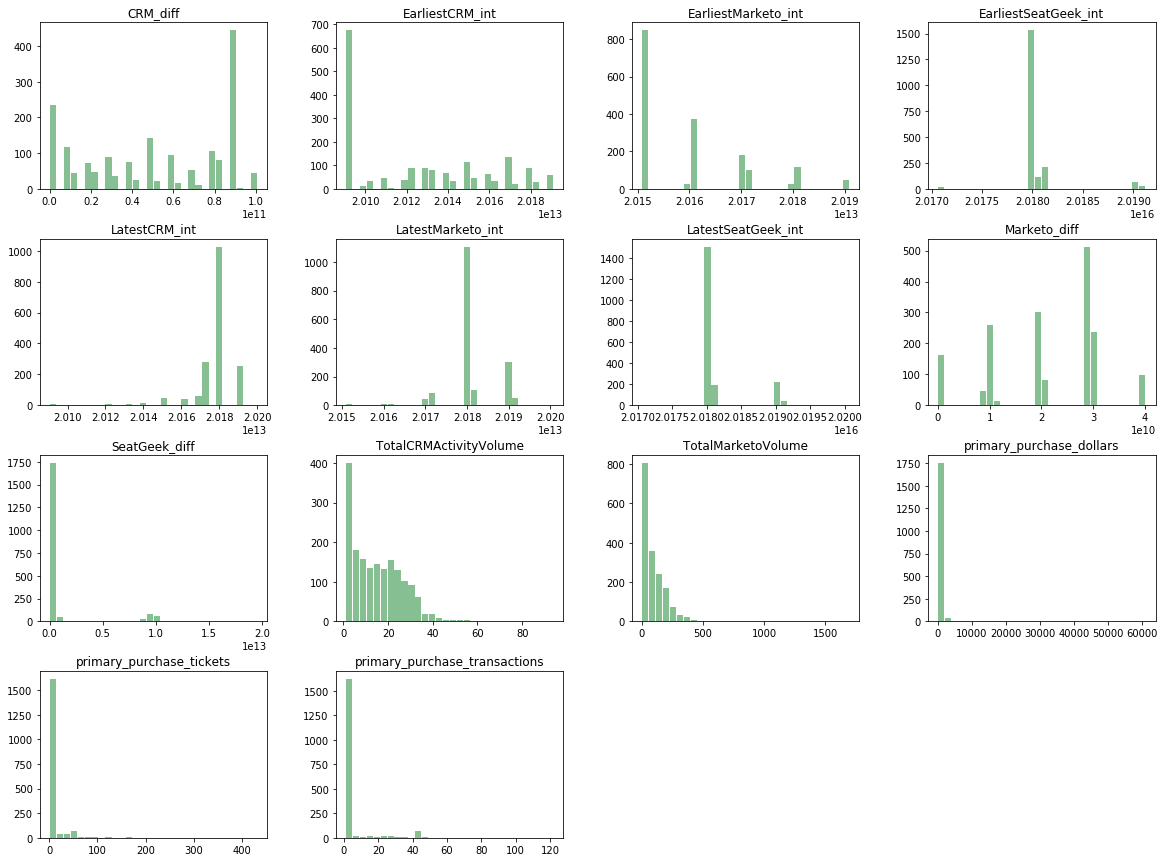

In [14]:
ax = STM.hist(bins=30, grid=False, figsize=(20,15), color='#86bf91', zorder=2, rwidth=0.9)

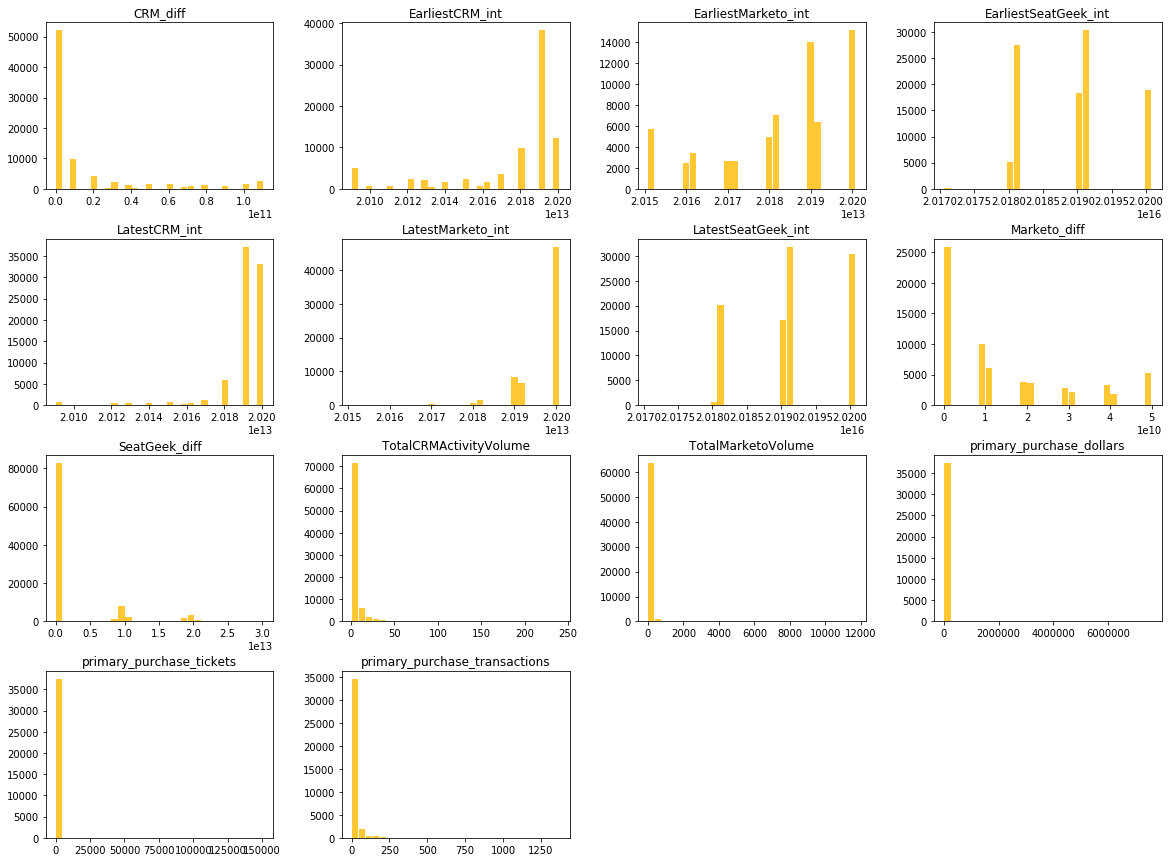

In [15]:
ax = nonSTM.hist(bins=30, grid=False, figsize=(20,15), color='#FFC733', zorder=2, rwidth=0.9)

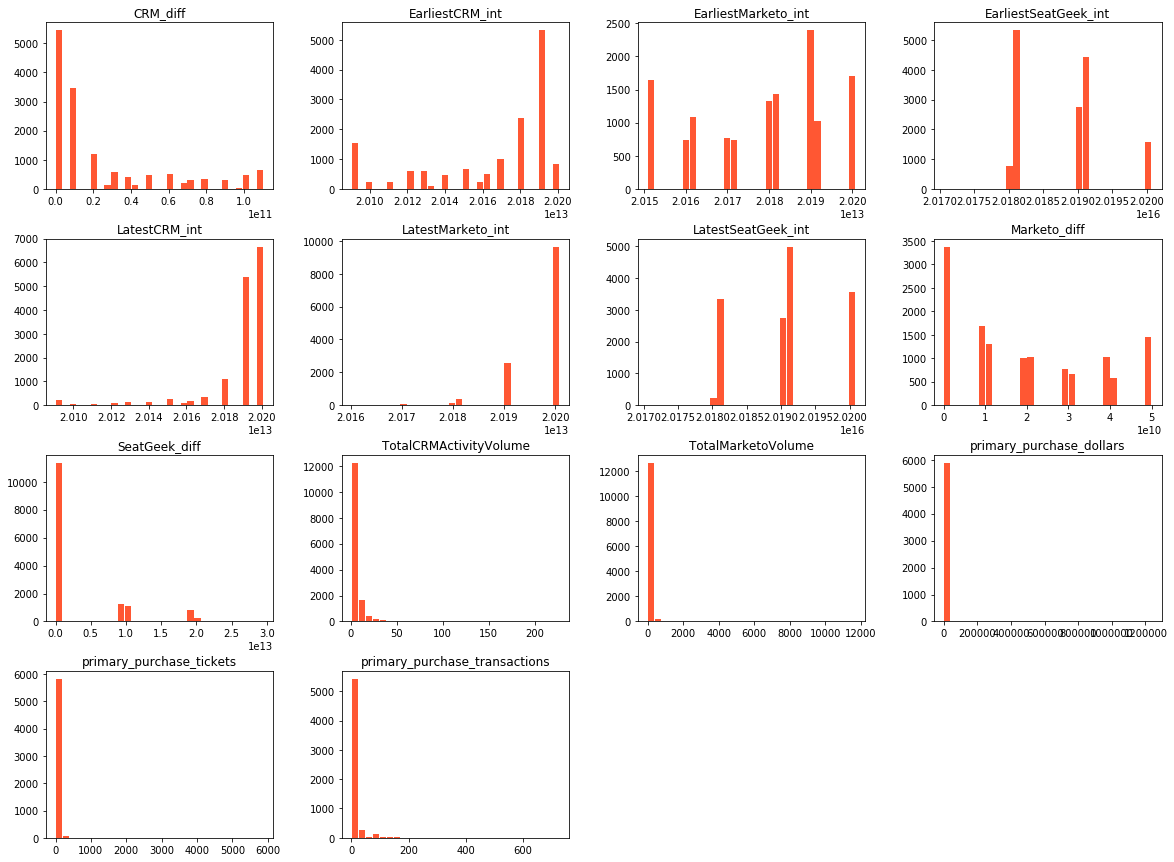

In [16]:
ax = lost.hist(bins=30, grid=False, figsize=(20,15), color='#FF5733', zorder=2, rwidth=0.9)

# Standardization & PCA

In [17]:
#STACK STM NONSTM, LOST

STM['target'] = 'STM'
lost['target'] = 'Rejecter'
nonSTM['target'] = 'nonSTM'

full_data = pd.concat([STM, nonSTM, lost])

In [18]:
#STANDARDIZE FEATURES

full_tmp = full_data.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()

scaler = StandardScaler()
scaler.fit(full_tmp)

full_standardized  = pd.DataFrame(scaler.transform(full_tmp))

In [19]:
#PCA

#PCA CLUSTERING
np.set_printoptions(precision=2, suppress=True)

#DECIDED ON # of Components = 5 to represent > 75% of variance
pca = PCA()
pca.fit(full_standardized)
np.cumsum(pca.explained_variance_/sum(pca.explained_variance_))

array([0.31, 0.48, 0.61, 0.7 , 0.77, 0.84, 0.89, 0.93, 0.96, 0.99, 1.  ,
       1.  , 1.  , 1.  ])

In [20]:
#DECIDED ON # of Components = 5 to represent > 75% of variance
pca = PCA(n_components=5)
pca.fit(full_standardized)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [21]:
#BUILD ATTRIBUTES INFO FOR PCA INTERPRETATION
# full_tmp.columns
attributes_info = pd.DataFrame(columns = ['Attribute', 'Description'])
attributes_info = attributes_info.append({'Attribute':0, 'Description': 'TotalCRMAcvtivty Volume'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':1, 'Description': 'TotalMarketoVolume'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':2, 'Description': 'primary_purchase_transactions'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':3, 'Description': 'primary_purchase_dollars'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':4, 'Description': 'primary_purchase_tickets'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':5, 'Description': 'EarliestCRM_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':6, 'Description': 'LatestCRM_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':7, 'Description': 'LatestSeatGeek_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':8, 'Description': 'EarliestSeatGeek_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':9, 'Description': 'EarliestMarketo_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':10, 'Description': 'LatestMarketo_int'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':11, 'Description': 'CRM_diff'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':12, 'Description': 'SeatGeek_diff'}, ignore_index = True)
attributes_info = attributes_info.append({'Attribute':13, 'Description': 'Marketo_diff'}, ignore_index = True)
attributes_info

,Attribute,Description
0,0,TotalCRMAcvtivty Volume
1,1,TotalMarketoVolume
2,2,primary_purchase_transactions
3,3,primary_purchase_dollars
4,4,primary_purchase_tickets
5,5,EarliestCRM_int
6,6,LatestCRM_int
7,7,LatestSeatGeek_int
8,8,EarliestSeatGeek_int
9,9,EarliestMarketo_int


In [22]:
#PCA
#display weights and direction of components
def plot_feature_weights(df, pca, attributes_info, dimension, n_weights, plot=True, figsize=(5,10)):
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes_info.Attribute.values:
            feat_descs.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values(by =["FeatureWeight"], inplace=True, ascending=False)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

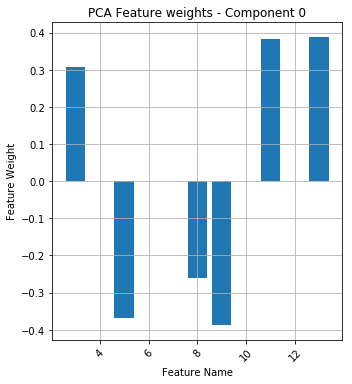

,Feature,Description,FeatureWeight
2,13,Marketo_diff,0.388679
1,11,CRM_diff,0.382082
0,3,primary_purchase_dollars,0.308491
5,8,EarliestSeatGeek_int,-0.260681
4,5,EarliestCRM_int,-0.369438
3,9,EarliestMarketo_int,-0.387960


In [23]:
component_0_info = plot_feature_weights(full_standardized, pca, attributes_info, 0, 3)
component_0_info.head(10)

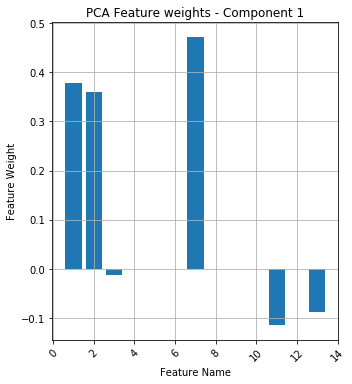

,Feature,Description,FeatureWeight
2,7,LatestSeatGeek_int,0.471678
1,1,TotalMarketoVolume,0.377412
0,2,primary_purchase_transactions,0.359372
5,3,primary_purchase_dollars,-0.011317
4,13,Marketo_diff,-0.086726
3,11,CRM_diff,-0.114550


In [24]:
component_1_info = plot_feature_weights(full_standardized, pca, attributes_info, 1, 3)
component_1_info.head(10)

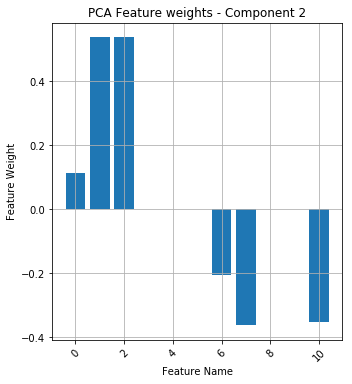

,Feature,Description,FeatureWeight
2,2,primary_purchase_transactions,0.539049
1,1,TotalMarketoVolume,0.537877
0,0,TotalCRMAcvtivty Volume,0.114243
5,6,LatestCRM_int,-0.205244
4,10,LatestMarketo_int,-0.350761
3,7,LatestSeatGeek_int,-0.362785


In [25]:
component_2_info = plot_feature_weights(full_standardized, pca, attributes_info, 2, 3)
component_2_info.head(10)

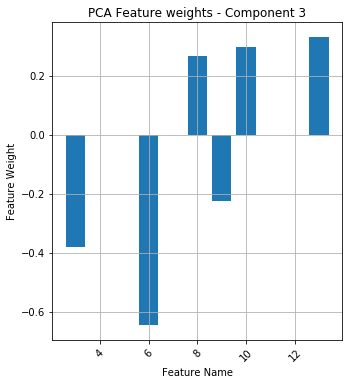

,Feature,Description,FeatureWeight
2,13,Marketo_diff,0.331221
1,10,LatestMarketo_int,0.297085
0,8,EarliestSeatGeek_int,0.267894
5,9,EarliestMarketo_int,-0.224600
4,3,primary_purchase_dollars,-0.380409
3,6,LatestCRM_int,-0.646147


In [26]:
component_3_info = plot_feature_weights(full_standardized, pca, attributes_info, 3, 3)
component_3_info.head(10)

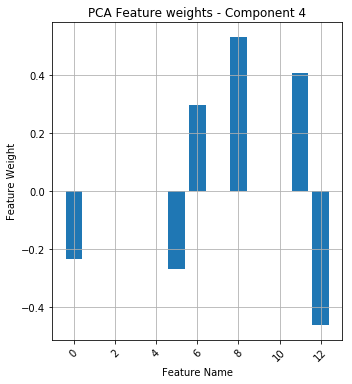

,Feature,Description,FeatureWeight
2,8,EarliestSeatGeek_int,0.531913
1,11,CRM_diff,0.406607
0,6,LatestCRM_int,0.298732
5,0,TotalCRMAcvtivty Volume,-0.233907
4,5,EarliestCRM_int,-0.268640
3,12,SeatGeek_diff,-0.461479


In [27]:
component_4_info = plot_feature_weights(full_standardized, pca, attributes_info, 4, 3)
component_4_info.head(10)

# Unsupervised: Clustering STM and Lost

For n_clusters = 2 The average silhouette_score is : 0.4164683719195629
For n_clusters = 3 The average silhouette_score is : 0.39526635920227876
For n_clusters = 4 The average silhouette_score is : 0.2921666505383061
For n_clusters = 5 The average silhouette_score is : 0.3088263590632571
For n_clusters = 6 The average silhouette_score is : 0.3197744058220088
For n_clusters = 7 The average silhouette_score is : 0.33864607318555245
For n_clusters = 8 The average silhouette_score is : 0.2987975503254404
For n_clusters = 9 The average silhouette_score is : 0.29091201166837116


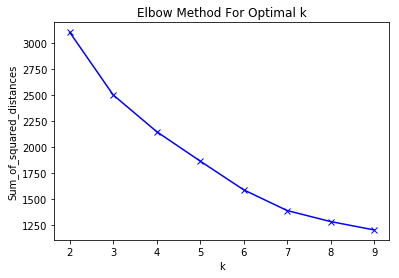

In [28]:
##STM CLUSTERING

df = STM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
stm_standardized  = pd.DataFrame(scaler.transform(df))
stm_pca = pca.transform(stm_standardized)


Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(stm_pca)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(stm_pca, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [29]:
##STM CLUSTERING - No real elbow in the char above so picked 5 clusters based on domain knowledge
k = 5
stm_kmeans = cluster.KMeans(n_clusters=k)
stm_kmeans.fit(stm_pca)

train_labels = stm_kmeans.predict(stm_pca)
stm_pred  = pd.DataFrame(stm_pca)
stm_pred['Cluster'] = train_labels
stm_pred['Cluster'].value_counts()

4    595
0    430
2    245
1    148
3     81
Name: Cluster, dtype: int64

In [30]:
##APPLY STM CLUSTERING to NONSTM
df = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
nonstm_standardized  = pd.DataFrame(scaler.transform(df))
nonstm_pca = pca.transform(nonstm_standardized)

train_labels = stm_kmeans.predict(nonstm_pca)
nonstm_pred  = pd.DataFrame(nonstm_pca)
nonstm_pred['Cluster_STM'] = train_labels
nonstm_pred['Cluster_STM'].value_counts()

1    22641
2     1738
4     1248
3      642
0      228
Name: Cluster_STM, dtype: int64

For n_clusters = 2 The average silhouette_score is : 0.32185025408077633
For n_clusters = 3 The average silhouette_score is : 0.3400442955059391
For n_clusters = 4 The average silhouette_score is : 0.28783966880939577
For n_clusters = 5 The average silhouette_score is : 0.292256734979924
For n_clusters = 6 The average silhouette_score is : 0.3226284534605702
For n_clusters = 7 The average silhouette_score is : 0.31752339254248213
For n_clusters = 8 The average silhouette_score is : 0.3082045883204743
For n_clusters = 9 The average silhouette_score is : 0.30547642687458215


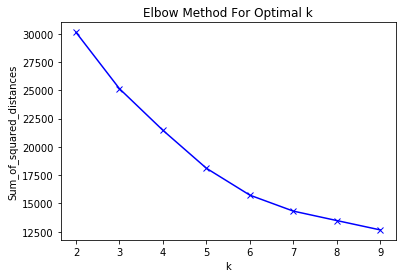

In [31]:
##LOST CLUSTERING

df = lost.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
lost_standardized  = pd.DataFrame(scaler.transform(df))
lost_pca = pca.transform(lost_standardized)

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(lost_pca)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(lost_pca, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [32]:
##LOST CLUSTERING - Slight elbow at 6 but chose 5 based on domain knowledge ans consistency with STM clusters
k = 5
lost_kmeans = cluster.KMeans(n_clusters=k)
lost_kmeans.fit(stm_pca)

train_labels = lost_kmeans.predict(lost_pca)
lost_pred  = pd.DataFrame(lost_pca)
lost_pred['Cluster'] = train_labels
lost_pred['Cluster'].value_counts()

3    3011
4    2047
1     159
0      57
2      44
Name: Cluster, dtype: int64

In [33]:
##APPLY LOST CLUSTERING to NONSTM
df = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna()
nonstm_standardized  = pd.DataFrame(scaler.transform(df))
nonstm_pca = pca.transform(nonstm_standardized)

train_labels = lost_kmeans.predict(nonstm_pca)
#nonstm_pred  = pd.DataFrame(nonstm_pca)
nonstm_pred['Cluster_lost'] = train_labels
nonstm_pred['Cluster_lost'].value_counts()

3    17103
4     8321
1      706
0      234
2      133
Name: Cluster_lost, dtype: int64

In [34]:
#COMPARE CLUSTER BREAKDOWNS

cluster_info = pd.DataFrame([])

cluster_info["STM"] = stm_pred['Cluster'].value_counts().sort_index()
cluster_info["Population_STM"] = nonstm_pred['Cluster_STM'].value_counts().sort_index()
cluster_info["Lost"] = lost_pred['Cluster'].value_counts().sort_index()
cluster_info["Population_Lost"] = nonstm_pred['Cluster_lost'].value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

In [35]:
cluster_info

,Cluster,STM,Population_STM,Lost,Population_Lost
0,0,430,228,57,234
1,1,148,22641,159,706
2,2,245,1738,44,133
3,3,81,642,3011,17103
4,4,595,1248,2047,8321


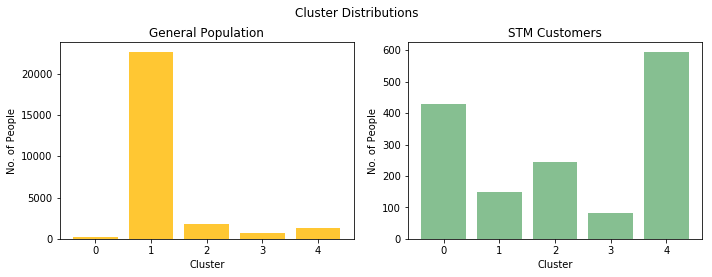

In [36]:
#VISUALIZE STM CLUSTER BREAKDOWNS

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population_STM"], color=(255/255, 199/255, 51/255))
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["STM"], color=(134/255, 191/255, 145/255))
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("STM Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

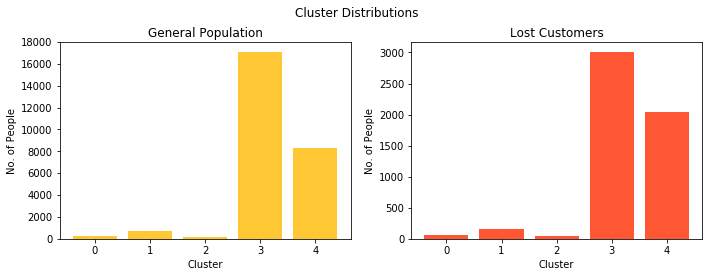

In [37]:
#VISUALIZE REJECTER/LOST CLUSTER BREAKDOWNS

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population_Lost"], color=(255/255, 199/255, 51/255))
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")

ax2.bar(cluster_info["Cluster"], cluster_info["Lost"], color=(255/255, 87/255, 51/255))
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Lost Customers")

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [38]:
#Calculate cluster proportions

cluster_info["Population_STM_proportion"] = (cluster_info["Population_STM"]/cluster_info["Population_STM"].sum()*100).round(2)
cluster_info["STM_proportion"] = (cluster_info["STM"]/cluster_info["STM"].sum()*100).round(2)
cluster_info["Population_Lost_proportion"] = (cluster_info["Population_Lost"]/cluster_info["Population_Lost"].sum()*100).round(2)
cluster_info["Lost_proportion"] = (cluster_info["Lost"]/cluster_info["Lost"].sum()*100).round(2)

cluster_info["STM_over_Pop"] = cluster_info["STM_proportion"] / cluster_info["Population_STM_proportion"]
cluster_info["Lost_over_Pop"] = cluster_info["Lost_proportion"] / cluster_info["Population_Lost_proportion"]


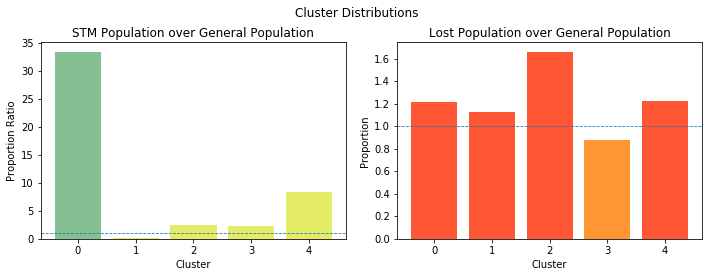

In [39]:
#Visualize Population proportions vs STM and Lost/Rejecter clusters 

fig, (ax, ax2) = plt.subplots(1,2, figsize=(10, 4))

mask1 = cluster_info["STM_over_Pop"] < 10
mask2 = cluster_info["STM_over_Pop"] >= 10

ax.bar(cluster_info["Cluster"][mask1], cluster_info["STM_over_Pop"][mask1], color=(228/255, 235/255, 103/255))
ax.bar(cluster_info["Cluster"][mask2], cluster_info["STM_over_Pop"][mask2], color=(134/255, 191/255, 145/255))

ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion Ratio")
ax.set_title("STM Population over General Population")
ax.axhline(y=1, linestyle = "--", linewidth = 0.8)


mask1 = cluster_info["Lost_over_Pop"] < 1
mask2 = cluster_info["Lost_over_Pop"] >= 1

ax2.bar(cluster_info["Cluster"][mask1], cluster_info["Lost_over_Pop"][mask1], color=(255/255, 150/255, 51/255))
ax2.bar(cluster_info["Cluster"][mask2], cluster_info["Lost_over_Pop"][mask2], color=(255/255, 87/255, 51/255))

ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion")
ax2.set_title("Lost Population over General Population")
ax2.axhline(y=1, linestyle = "--", linewidth = 0.8)


fig.suptitle("Cluster Distributions")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [40]:
cluster_info

,Cluster,STM,Population_STM,Lost,Population_Lost,Population_STM_proportion,STM_proportion,Population_Lost_proportion,Lost_proportion,STM_over_Pop,Lost_over_Pop
0,0,430,228,57,234,0.86,28.69,0.88,1.07,33.360465,1.215909
1,1,148,22641,159,706,85.45,9.87,2.66,2.99,0.115506,1.124060
2,2,245,1738,44,133,6.56,16.34,0.50,0.83,2.490854,1.660000
3,3,81,642,3011,17103,2.42,5.40,64.55,56.62,2.231405,0.877149
4,4,595,1248,2047,8321,4.71,39.69,31.40,38.49,8.426752,1.225796


In [41]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=3, num_feat_per_comp=2):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes_info, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info.drop(['Description'], axis = 1)

In [42]:
cluster_0 = explain_cluster(stm_kmeans, 0, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_0

,Component,ComponentWeight,Feature,FeatureWeight
0,2,1.951816,primary_purchase_tickets,0.539049
1,2,1.951816,primary_purchase_dollars,0.537877
2,2,1.951816,LatestMarketo_int,-0.350761
3,2,1.951816,LatestSeatGeek_int,-0.362785
4,0,0.929874,Marketo_diff,0.388679
5,0,0.929874,CRM_diff,0.382082
6,0,0.929874,EarliestCRM_int,-0.369438
7,0,0.929874,EarliestMarketo_int,-0.387960
8,4,-0.248109,EarliestSeatGeek_int,0.531913
9,4,-0.248109,CRM_diff,0.406607


In [43]:
cluster_1 = explain_cluster(stm_kmeans, 1, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_1

,Component,ComponentWeight,Feature,FeatureWeight
0,2,0.638461,primary_purchase_tickets,0.539049
1,2,0.638461,primary_purchase_dollars,0.537877
2,2,0.638461,LatestMarketo_int,-0.350761
3,2,0.638461,LatestSeatGeek_int,-0.362785
4,0,0.164097,Marketo_diff,0.388679
5,0,0.164097,CRM_diff,0.382082
6,0,0.164097,EarliestCRM_int,-0.369438
7,0,0.164097,EarliestMarketo_int,-0.387960
8,3,-0.148381,Marketo_diff,0.331221
9,3,-0.148381,LatestMarketo_int,0.297085


In [44]:
cluster_4 = explain_cluster(lost_kmeans, 4, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_4

,Component,ComponentWeight,Feature,FeatureWeight
0,0,1.671276,Marketo_diff,0.388679
1,0,1.671276,CRM_diff,0.382082
2,0,1.671276,EarliestCRM_int,-0.369438
3,0,1.671276,EarliestMarketo_int,-0.387960
4,2,0.765077,primary_purchase_tickets,0.539049
5,2,0.765077,primary_purchase_dollars,0.537877
6,2,0.765077,LatestMarketo_int,-0.350761
7,2,0.765077,LatestSeatGeek_int,-0.362785
8,3,-0.060090,Marketo_diff,0.331221
9,3,-0.060090,LatestMarketo_int,0.297085


In [45]:
cluster_3 = explain_cluster(lost_kmeans, 3, nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).dropna(), pca, attributes_info)
cluster_3

,Component,ComponentWeight,Feature,FeatureWeight
0,2,0.753468,primary_purchase_tickets,0.539049
1,2,0.753468,primary_purchase_dollars,0.537877
2,2,0.753468,LatestMarketo_int,-0.350761
3,2,0.753468,LatestSeatGeek_int,-0.362785
4,3,-0.397728,Marketo_diff,0.331221
5,3,-0.397728,LatestMarketo_int,0.297085
6,3,-0.397728,TotalCRMActivityVolume,-0.380409
7,3,-0.397728,LatestCRM_int,-0.646147
8,1,-0.626522,LatestSeatGeek_int,0.471678
9,1,-0.626522,primary_purchase_dollars,0.377412


# Supervised: STM or Rejecter/Lost Classification

In [46]:
#SPLIT full_data
full_data = pd.concat([STM, nonSTM, lost])
full_df = full_data.dropna()
full_df = full_df.loc[full_df['target']!='nonSTM',]
print(full_df['target'].value_counts())
full_df['target'].value_counts()/len(full_df)

Rejecter    5318
STM         1499
Name: target, dtype: int64


Rejecter    0.780109
STM         0.219891
Name: target, dtype: float64

In [47]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    
    model = model.fit(X_train, y_train)
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    return roc_score

In [48]:


models = [("LogisticRegression", LogisticRegression(random_state=42)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=42))]


X = full_df.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1)
y = full_df['target']

#HOLDOUT
#X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, test_size=0.1)

#KFOLD
# kf = StratifiedKFold(n_splits=5) # Define the split - into 5 folds 
# kf.get_n_splits(X_use, y_use) 

kf = KFold(n_splits=5) # Define the split - into 5 folds 
kf.get_n_splits(X_use) 

results = {"Model":[],
          "AUCROC_score":[]}
for name, model in models:
    roc = 0
#     for train_index, test_index in kf.split(X_use, y_use):
    for train_index, test_index in kf.split(X_use):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_use.iloc[train_index], X_use.iloc[test_index]
        y_train, y_test = y_use.iloc[train_index], y_use.iloc[test_index]
        
        r = train_and_predict(model, X_train, y_train, X_test, y_test)
        roc += r
    results["Model"].append(name)
    results["AUCROC_score"].append(roc/5)
    
#SKLEARN MODELS + PYTORCH MODEL

TRAIN: [1227 1228 1229 ... 6132 6133 6134] TEST: [   0    1    2 ... 1224 1225 1226]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [1227 1228 1229 ... 2451 2452 2453]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [2454 2455 2456 ... 3678 3679 3680]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [3681 3682 3683 ... 4905 4906 4907]
TRAIN: [   0    1    2 ... 4905 4906 4907] TEST: [4908 4909 4910 ... 6132 6133 6134]
TRAIN: [1227 1228 1229 ... 6132 6133 6134] TEST: [   0    1    2 ... 1224 1225 1226]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [1227 1228 1229 ... 2451 2452 2453]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [2454 2455 2456 ... 3678 3679 3680]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [3681 3682 3683 ... 4905 4906 4907]
TRAIN: [   0    1    2 ... 4905 4906 4907] TEST: [4908 4909 4910 ... 6132 6133 6134]
TRAIN: [1227 1228 1229 ... 6132 6133 6134] TEST: [   0    1    2 ... 1224 1225 1226]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [1227 1228 1229 ... 2451 2452 2453]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [2454 2455 2456 ... 3678 3679 3680]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [3681 3682 3683 ... 4905 4906 4907]
TRAIN: [   0    1    2 ... 4905 4906 4907] TEST: [4908 4909 4910 ... 6132 6133 6134]
TRAIN: [1227 1228 1229 ... 6132 6133 6134] TEST: [   0    1    2 ... 1224 1225 1226]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [1227 1228 1229 ... 2451 2452 2453]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [2454 2455 2456 ... 3678 3679 3680]
TRAIN: [   0    1    2 ... 6132 6133 6134] TEST: [3681 3682 3683 

In [49]:
print(f"Holdout Class Proportion:\n{y_holdout.value_counts()/len(y_holdout)}\n")
print(f"Train Class Proportion:\n{y_train.value_counts()/len(y_train)}\n")
print(f"Test Class Proportion:\n{y_test.value_counts()/len(y_test)}\n")

Holdout Class Proportion:
Rejecter    0.778592
STM         0.221408
Name: target, dtype: float64

Train Class Proportion:
Rejecter    0.77934
STM         0.22066
Name: target, dtype: float64

Test Class Proportion:
Rejecter    0.784026
STM         0.215974
Name: target, dtype: float64



In [50]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,LogisticRegression,0.5
1,DecisionTreeClassifier,0.968825
2,RandomForestClassifier,0.997741
3,GradientBoostingClassifier,0.998576
4,AdaBoostClassifier,0.997389
5,XGBClassifier,0.998871


In [51]:
#TRAIN BEST MODEL
model = xgb.XGBClassifier(random_state=42).fit(X_use, y_use)

In [52]:
#TEST ON HOLDOUT

roc_score = roc_auc_score(y_holdout, model.predict_proba(X_holdout)[:,1])
print(f"Holdout ROC: {roc_score} \n")
r = recall_score(y_holdout, model.predict(X_holdout), pos_label='STM')
print(f"Holdout Recall: {r} \n")
p = precision_score(y_holdout, model.predict(X_holdout), pos_label='STM')
print(f"Precision Recall: {p} \n")


Holdout ROC: 0.9986655192626682 

Holdout Recall: 0.9801324503311258 

Precision Recall: 0.9673202614379085 



In [53]:
#TEST ON HOLDOUT - -biased only STM

#roc_score = roc_auc_score(y_holdout, model.predict_proba(X_holdout)[:,1])
print(f"Holdout ROC: No ROC for single class \n")
r = recall_score(y_holdout[y_holdout=='STM'], model.predict(X_holdout[y_holdout=='STM']), pos_label='STM')
print(f"Holdout Recall: {r} \n")
p = precision_score(y_holdout[y_holdout=='STM'], model.predict(X_holdout[y_holdout=='STM']), pos_label='STM')
print(f"Precision Recall: {p} \n")

Holdout ROC: No ROC for single class 

Holdout Recall: 0.9801324503311258 

Precision Recall: 1.0 



In [54]:
#TEST ON HOLDOUT - -biased only Rejecter

#roc_score = roc_auc_score(y_holdout, model.predict_proba(X_holdout)[:,1])
print(f"Holdout ROC: No ROC for single class \n")
r = recall_score(y_holdout[y_holdout=='Rejecter'], model.predict(X_holdout[y_holdout=='Rejecter']), pos_label='Rejecter')
print(f"Holdout Recall: {r} \n")
p = precision_score(y_holdout[y_holdout=='Rejecter'], model.predict(X_holdout[y_holdout=='Rejecter']), pos_label='Rejecter')
print(f"Precision Recall: {p} \n")

Holdout ROC: No ROC for single class 

Holdout Recall: 0.9905838041431262 

Precision Recall: 1.0 



In [55]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})')

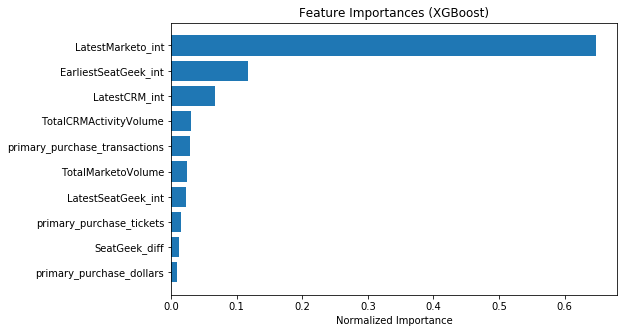

In [56]:
plot_feature_importances(model=model, model_name="XGBoost", feature_names=X_use.columns)


In [57]:
#DECISION TREE FOR INTERPRETABILITY
model = DecisionTreeClassifier(random_state=42, min_impurity_decrease = .001).fit(X_use, y_use)
roc_score = roc_auc_score(y_holdout, model.predict_proba(X_holdout)[:,1])
print(f"Holdout ROC: {roc_score} \n")
r = recall_score(y_holdout, model.predict(X_holdout), pos_label='STM')
print(f"Holdout Recall: {r} \n")
p = precision_score(y_holdout, model.predict(X_holdout), pos_label='STM')
print(f"Precision Recall: {p} \n")

Holdout ROC: 0.9807435676781283 

Holdout Recall: 0.9735099337748344 

Precision Recall: 0.9545454545454546 



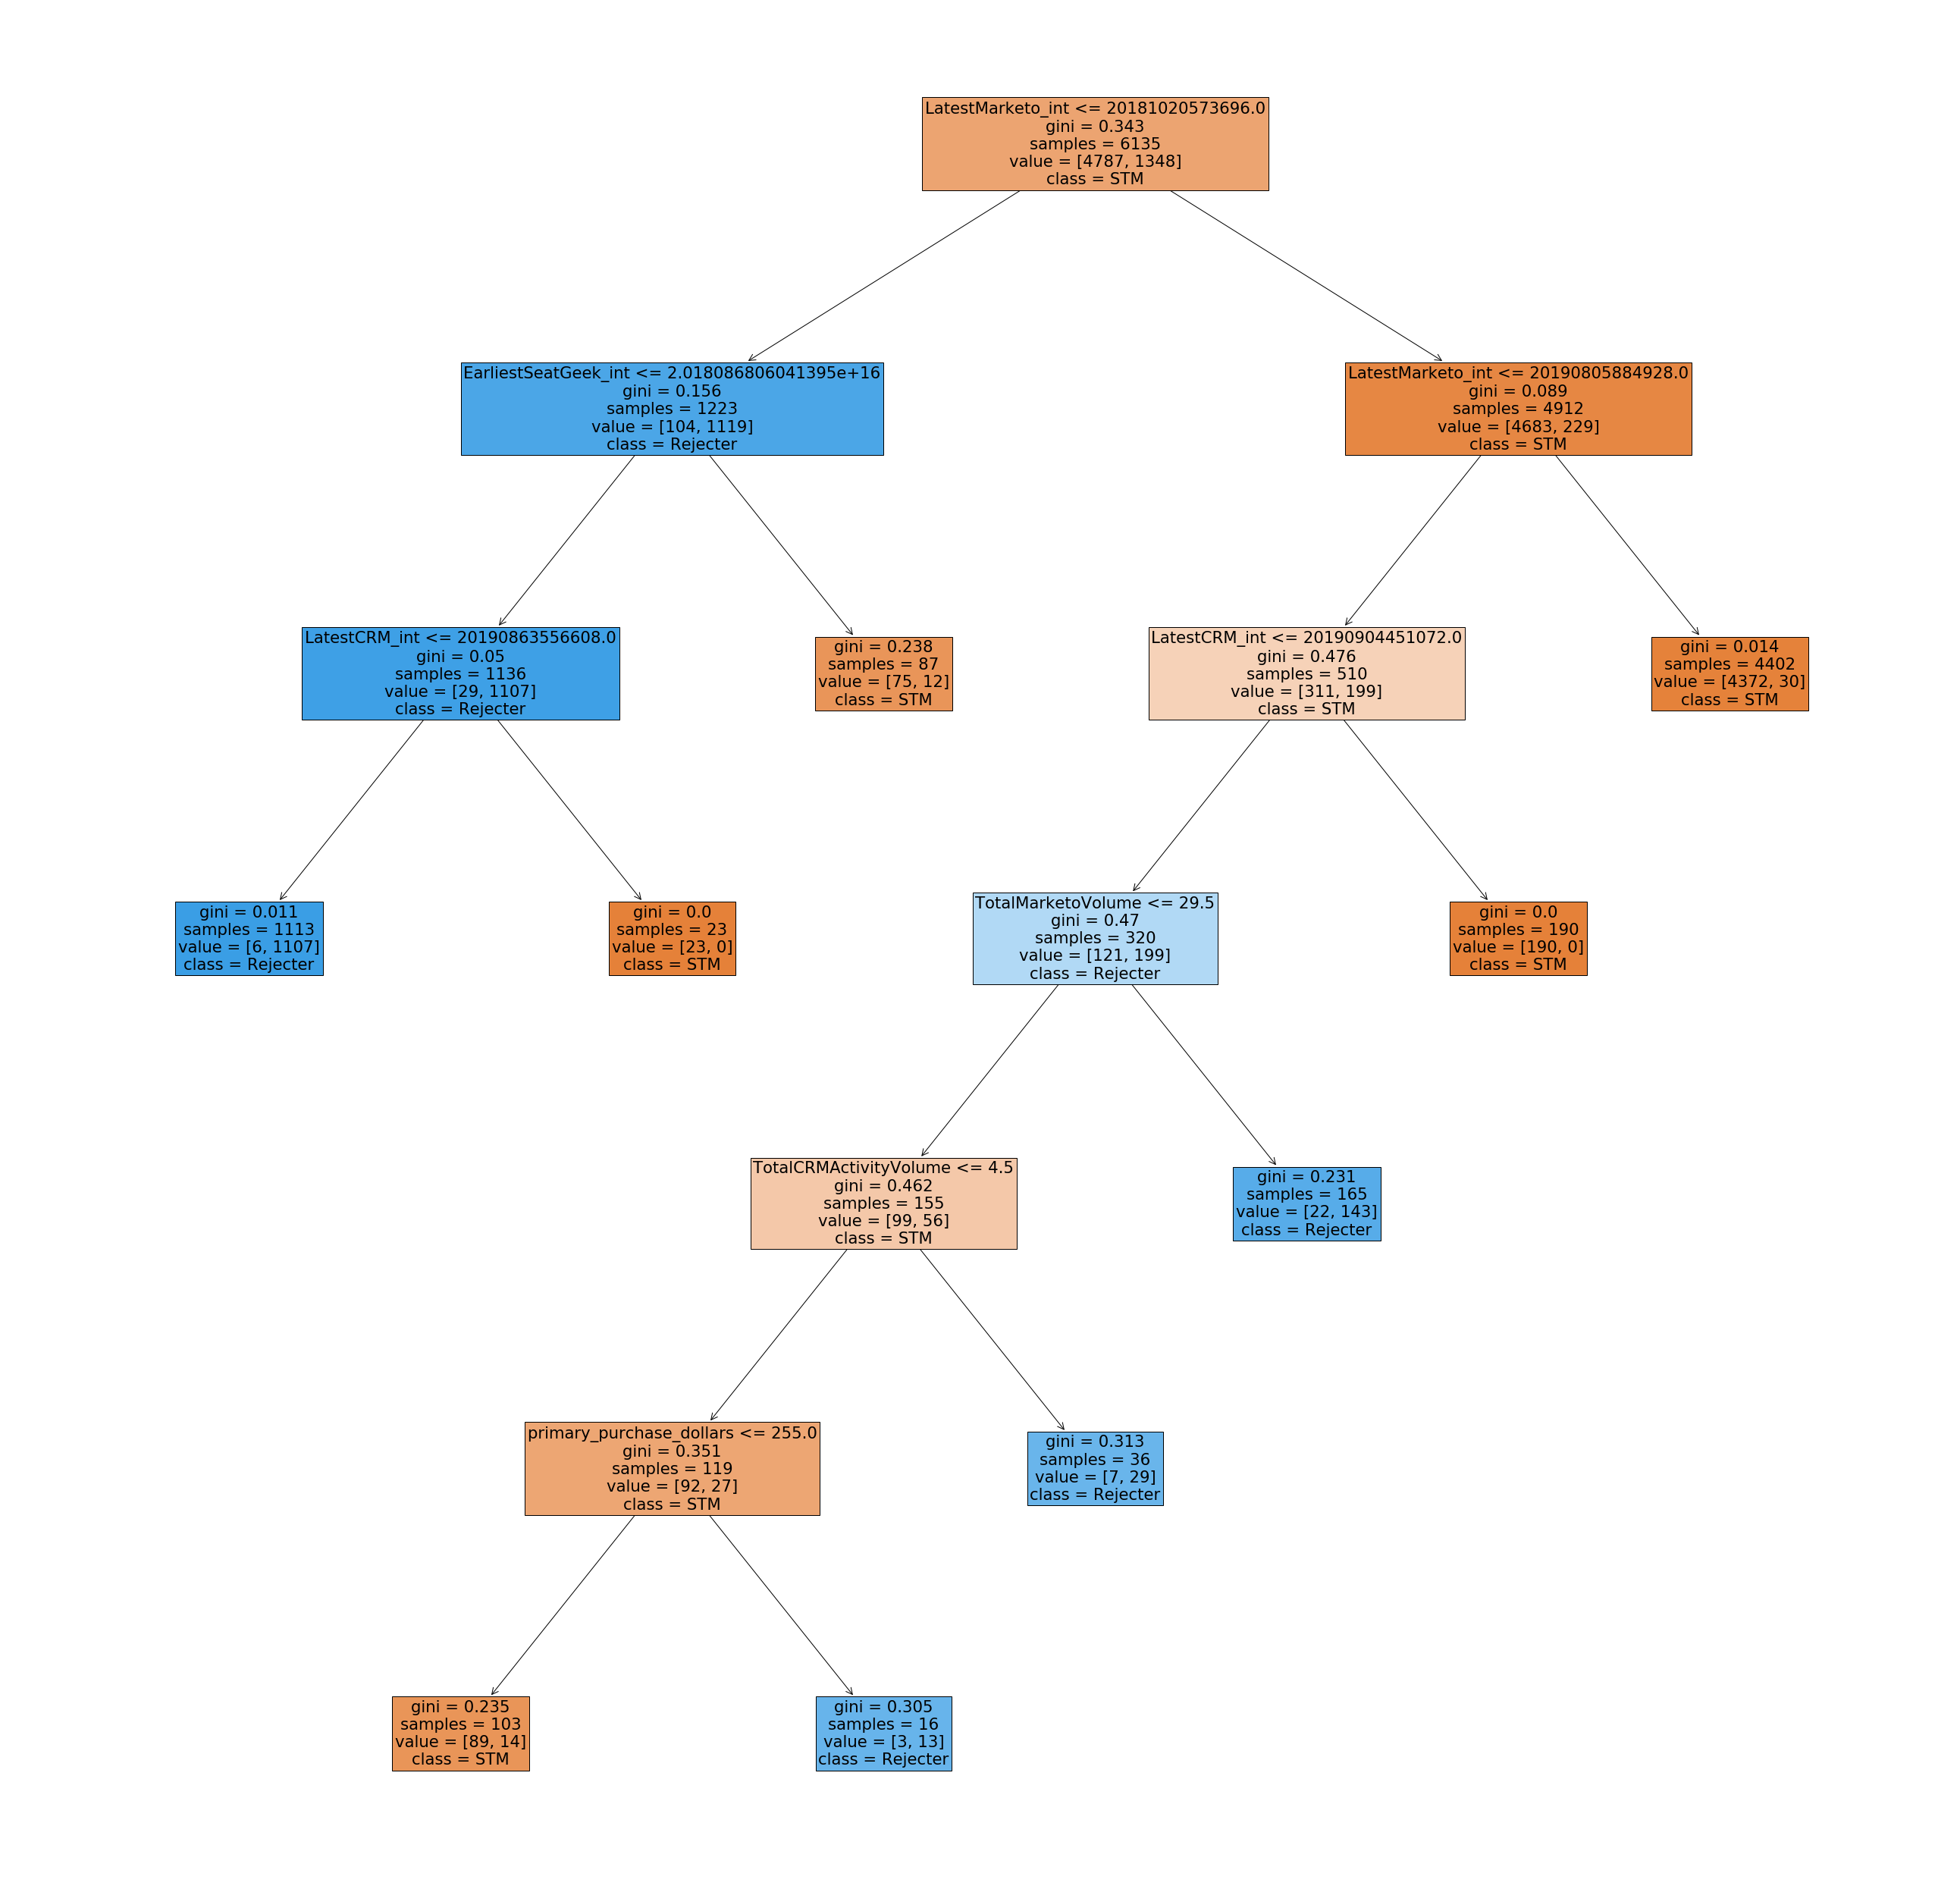

In [58]:
#PLOT TREE
plt.figure(figsize=(45,45))
plt.rcParams.update({'font.size':22})
tree.plot_tree(model, filled=True, feature_names = X_use.columns, class_names = ['STM', 'Rejecter'])
plt.show()

# Predict on nonSTM

In [59]:
nonSTMnew = nonSTM.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1).dropna()
pd.Series(model.predict(nonSTMnew)).value_counts()

Rejecter    26224
STM           273
dtype: int64

In [60]:
nonSTMnew[model.predict(nonSTMnew)=='STM']

,primary_purchase_transactions,primary_purchase_dollars,primary_purchase_tickets,TotalCRMActivityVolume,TotalMarketoVolume,EarliestCRM_int,LatestCRM_int,LatestSeatGeek_int,EarliestSeatGeek_int,EarliestMarketo_int,LatestMarketo_int,CRM_diff,SeatGeek_diff,Marketo_diff
57,1.0,280.0,8.0,1.0,22.0,2.019043e+13,2.019043e+13,20181027162205000,20180912091013380,2.018082e+13,2.019040e+13,0.000000e+00,115071191620,9.583021e+09
76,1.0,36.0,3.0,7.0,56.0,2.009052e+13,2.019072e+13,20190121023037327,20190121023037327,2.017013e+13,2.019072e+13,1.001971e+11,0,2.058800e+10
466,1.0,50.0,1.0,11.0,3.0,2.012121e+13,2.013091e+13,20170613115837733,20170613115837733,2.017090e+13,2.018080e+13,9.705133e+09,0,9.899938e+09
549,230.0,794416.0,1740.0,1.0,1.0,2.009052e+13,2.009052e+13,20191212132530447,20180327083810907,2.018031e+13,2.018031e+13,0.000000e+00,10885048719540,0.000000e+00
1346,1.0,0.0,2.0,1.0,35.0,2.016121e+13,2.016121e+13,20181204180624000,20181002125351503,2.017013e+13,2.019072e+13,0.000000e+00,202055272497,2.059283e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96648,310.0,214821.0,1399.0,2.0,4.0,2.014031e+13,2.016100e+13,20200331151235180,20180327084332657,2.019031e+13,2.019031e+13,2.069299e+10,20004066902523,5.829294e+06
97201,1.0,500.0,2.0,6.0,264.0,2.009053e+13,2.018102e+13,20190204213628000,20181116225809223,2.015092e+13,2.019072e+13,9.049001e+10,9087987818777,3.980308e+10
97987,1.0,100.0,1.0,6.0,15.0,2.013073e+13,2.013101e+13,20170613115844517,20170613115844517,2.016072e+13,2.017052e+13,2.800098e+08,0,9.804016e+09
98800,2.0,0.0,8.0,1.0,30.0,2.018032e+13,2.018032e+13,20181002191850860,20181002190810283,2.018093e+13,2.019023e+13,0.000000e+00,1040577,9.298079e+09
